<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_FFN_MNIST_weightHistograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [3]:
# shape of the data matrix
data.shape

(20000, 785)

In [4]:
# extract labels (numbers IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [ ]:
# # normalize the data to a range of [0 1]
# dataNorm = (data - np.min(data)) / (np.max(data) - np.min(data))

# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].hist(data.flatten(), 50)
# ax[0].set_xlabel('Pixel intensity values')
# ax[0].set_ylabel('Count')
# ax[0].set_title("Histogram of original data")
# ax[0].set_yscale('log')

# ax[1].hist(dataNorm.flatten(), 50)
# ax[1].set_xlabel('Pixel intensity values')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Histogram of normalized data')
# ax[1].set_yscale('log')

# plt.show()

## Create train/test groups using dataloader

In [5]:
# step 1: convert to tensor
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long() # long = int64

# step 2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = (train_data - torch.min(train_data)) / (torch.max(train_data) - torch.min(train_data))

test_data = (test_data - torch.min(test_data)) / (torch.max(test_data) - torch.min(test_data))


# step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [6]:
print('Training data range %g to %g'%(torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))
print('Test data range %g to %g'%(torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training data range 0 to 1
Test data range 0 to 1


In [7]:
# check all variables in workspace
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
batchsize          int              32
data               ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT              Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
display            module           <module 'IPython.display'<...>ages/IPython/display.py'>
labels             ndarray          20000: 20000 elems, type `float64`, 160000 bytes (156.25 kb)
labelsT            Tensor           tensor([6, 5, 7,  ..., 2, 9, 5])
nn                 module           <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np                 module           <module 'numpy' 

## Create the DL model

In [8]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

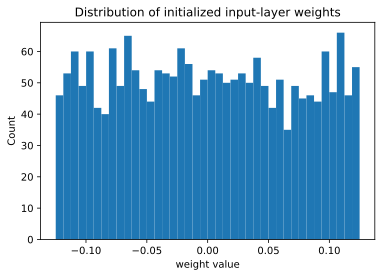

In [16]:
### exploring the "innards" of the model

# create a temp model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
# print('Summary of model:')
# print(net)
# print(' ')

# ## explore one of the layers
# print('Summary of input layer:')
# print(vars(net.input))
# print(' ')

# ## check out the matrix of weights
# print('Input layer weights: ')
# print(net.input.weight.shape)
# print(net.input.weight)
# print(' ')

## finally, extract the weights and make a histogram
w = net.fc1.weight.detach().flatten()
plt.hist(w, 40)
plt.xlabel('weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input-layer weights')
plt.show()

In [17]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

    # initialize weight vector
    W = np.array([])

    # concatenate each set of weights
    for layer in net.parameters():
        W = np.concatenate((W, net.fc1.weight.detach().flatten().numpy()))

    # compute their histogram (note: range is hard-coded)
    histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
    histx = (histx[1:] + histx[:-1]) / 2
    return histx, histy

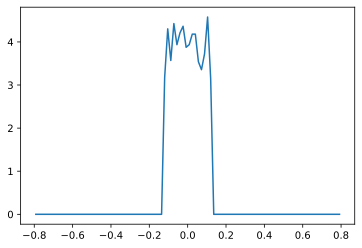

In [18]:
# test it!
histx, histy = weightsHistogram(net)
plt.plot(histx, histy)

In [ ]:
# test the model with one batch
net, lossfun, optimizer = createTheMNISTNet()

X, y = iter(train_loader).next()
yHat = net(X)
# value s are log-probability of each number (0-9)
print(yHat.shape)
# now let's compute the loss
loss = lossfun(yHat, y)
print(' ')
print('Loss: ')
print(loss)

torch.Size([32, 10])
 
Loss: 
tensor(4.0884, grad_fn=<NllLossBackward0>)


In [22]:
def function2trainTheModel():

    # number of epochs
    numepochs = 100

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # initialize histogram variables
    histx = np.zeros((numepochs, 100))
    histy = np.zeros((numepochs, 100))

    # loop over epochs
    for epochi in range(numepochs):

        # get the weights distribution at the start of this epoch
        histx, histy[epochi, :] = weightsHistogram(net)

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))
        yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, testAcc, losses, net, histx, histy

## Run the model and show the results!

In [23]:
trainAcc, testAcc, losses, net, histx, histy = function2trainTheModel()

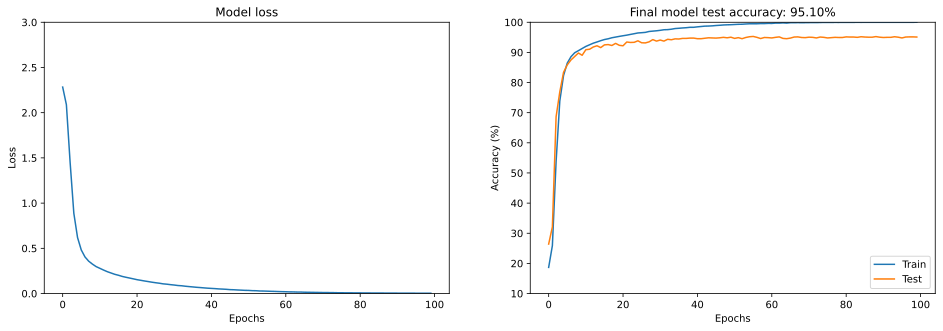

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

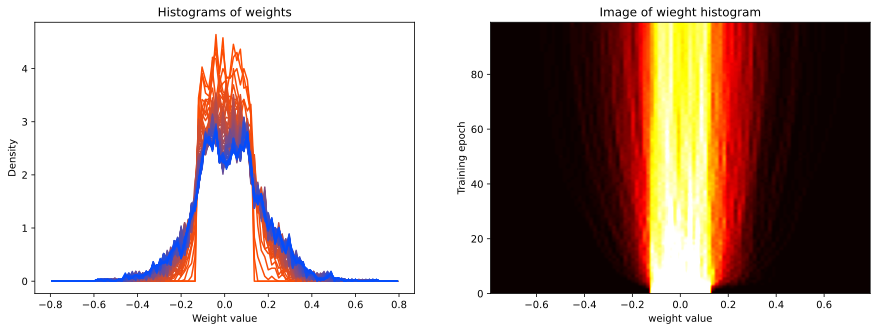

In [26]:
# show the histogram of the weights
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(histy.shape[0]):
    ax[0].plot(histx, histy[i, :], color=[1-i/100, .3, i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')

ax[1].imshow(histy, vmin=0, vmax=3, extent=[histx[0], histx[-1], 0, 99], aspect='auto', origin='top', cmap='hot')
ax[1].set_xlabel('weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of wieght histogram')
plt.show()